## Setup

In [1]:
import warnings
warnings.filterwarnings('ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from IPython.display import display

In [3]:
import pandas as pd
from PIL import Image
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch import tensor
from torch.utils.data import Dataset, DataLoader, RandomSampler, random_split
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from efficientnet_pytorch import EfficientNet
from torchvision import transforms
from collections import OrderedDict

import wandb
from pytorch_lightning.loggers import WandbLogger

pl.seed_everything(hash("setting random seeds") % 2**32 - 1)

2753784027

In [4]:
wandb.login()

wandb: Currently logged in as: sharif (use `wandb login --relogin` to force relogin)


True

In [9]:
p = {
    'WITH_DROPOUT': False,
    #'DROPOUT': 0.5,
    'BATCH_SZ': 256, # 64
    'TRAIN_VALID_SPLIT': 0.8,
    'L1_MULTI': 1.0,
    'L2_MULTI': 1.0,
    'L3_MULTI': 1.0,
    'W': 68, #68, 137
    'H': 118, #118, 236
    'MEAN': 0.93,
    'STD': 0.2,
    'MODEL': 'efficientnet-b0'
}

In [10]:
DATA1_F = 'data/train_image_data_0.feather'
DATA2_F = 'data/train_image_data_1.feather'
DATA3_F = 'data/train_image_data_2.feather'
DATA4_F = 'data/train_image_data_3.feather'
LABEL_F= 'data/train.csv'

## EDA

In [13]:
data1_df = pd.read_feather(DATA4_F)
label_df = pd.read_csv(LABEL_F)

In [14]:
len(data1_df), len(label_df)

(50210, 200840)

In [15]:
data1_df.head(5)

,image_id,0,1,2,3,4,5,6,7,8,...,32322,32323,32324,32325,32326,32327,32328,32329,32330,32331
0,Train_150630,246,245,244,244,245,247,246,244,247,...,252,252,251,251,251,251,251,252,253,252
1,Train_150631,213,241,247,247,246,247,246,244,247,...,193,198,200,202,200,196,194,192,175,117
2,Train_150632,253,253,252,252,251,252,253,253,253,...,253,253,253,253,253,253,253,253,253,253
3,Train_150633,252,252,252,252,252,252,252,252,252,...,255,255,255,255,255,255,255,255,255,255
4,Train_150634,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255


In [16]:
label_df.head(5)

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,Train_0,15,9,5,ক্ট্রো
1,Train_1,159,0,0,হ
2,Train_2,22,3,5,খ্রী
3,Train_3,53,2,2,র্টি
4,Train_4,71,9,5,থ্রো


In [19]:
def show_image(idx):
    img = data1_df.loc[idx][1:].to_numpy().reshape(137,236).astype(np.uint8)
    display(Image.fromarray(img))

### Examples

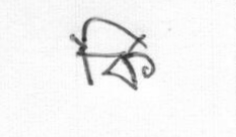

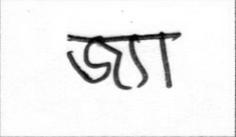

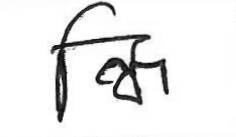

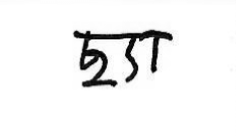

In [22]:
show_image(0); show_image(1); show_image(2); show_image(3);

## Dataset

In [11]:
class FeatherDS(Dataset):
    def __init__(self, f_files, label_f, tfms):
        self.labels = pd.read_csv(label_f)
        self.data_df = pd.DataFrame()
        self.tfms = tfms
        for f_file in f_files: 
            self.data_df = self.data_df.append(pd.read_feather(f_file))
        self.data_df.reset_index(inplace=True)
        
    def __len__(self): return len(self.data_df)
    
    def __getitem__(self, i):
        label   = self.labels.iloc[i]
        graph,vow,cons = label['grapheme_root'],label['vowel_diacritic'],label['consonant_diacritic']
        img = self.data_df.loc[i][2:].to_numpy().reshape(137,236).astype(np.uint8)
        return tfms(img), [graph,vow,cons]

In [12]:
tfms=transforms.Compose([transforms.ToTensor(),
                         transforms.Resize((p['W'],p['H'])),
                         transforms.Normalize(p['MEAN'], p['STD'])])

In [13]:
ds = FeatherDS([DATA1_F,DATA2_F,DATA3_F,DATA4_F], LABEL_F, tfms)

In [14]:
# sanity check
image,label = ds[211]
assert list(image.shape) == [1, p['W'], p['H']]
assert len(label) == 3

In [15]:
image.mean(), image.std()

(tensor(0.0984), tensor(0.7715))

## Model

In [16]:
n_cat_grapheme = 168
n_cat_vowel    = 11
n_consonant    = 7

In [17]:
def accuracy(y, y_hat): return (y_hat.argmax(dim=1) == y).float().mean()

In [18]:
def swish(x): return x*torch.sigmoid(x)

In [19]:
class Model(pl.LightningModule):
    def __init__(self, p):
        super().__init__()
        self.hparams = p
        self.save_hyperparameters()
        
        self.en = EfficientNet.from_pretrained(p['MODEL'], in_channels=1)
        self.conv1 = nn.Conv2d(1280, 20, 3, bias=False)
        self.conv2 = nn.Conv2d(1280, 4,  3, bias=False)
        self.conv3 = nn.Conv2d(1280, 3,  3, bias=False)
        self.bn1    = nn.BatchNorm2d(20)
        self.bn2    = nn.BatchNorm2d(4)
        self.bn3    = nn.BatchNorm2d(3)
        self.l1    = nn.Linear(40, n_cat_grapheme) # 40 360
        self.l2    = nn.Linear(8,  n_cat_vowel)    # 8 72
        self.l3    = nn.Linear(6,  n_consonant)    # 6 54
        
    def forward(self, x):
        y = self.en.extract_features(x)
        
        y1 = self.bn1(self.conv1(y))
        y2 = self.bn2(self.conv2(y))
        y3 = self.bn3(self.conv3(y))
        
        y1 = swish(y1)
        y2 = swish(y2)
        y3 = swish(y3)
    
        y1 = torch.flatten(y1, 1)
        y2 = torch.flatten(y2, 1)
        y3 = torch.flatten(y3, 1)

        y1 = self.l1(y1)
        y2 = self.l2(y2)
        y3 = self.l3(y3)
        
        return y1,y2,y3
    
    def step(self, batch, batch_idx):
        x,labels = batch
        graph,vow,cons = labels
        y1_hat,y2_hat,y3_hat = self(x)
        l1 = F.cross_entropy(y1_hat, graph)
        l2 = F.cross_entropy(y2_hat, vow)
        l3 = F.cross_entropy(y3_hat, cons)
        l = (p['L1_MULTI']*l1)+(p['L2_MULTI']*l2)+(p['L3_MULTI']*l3)
        acc1 = accuracy(graph, y1_hat)
        acc2 = accuracy(vow, y2_hat)
        acc3 = accuracy(cons, y3_hat)
        acc = (acc1+acc2+acc3)/3
        return OrderedDict({
            'l1':l1,
            'l2':l2,
            'l3':l3,
            'loss': l,
            'acc1': acc1,
            'acc2': acc2,
            'acc3': acc3,
            'accuracy': acc
        })
    
    def create_logs(self, outputs):
        loss = torch.stack([output['loss'] for output in outputs]).float().mean()
        acc = torch.stack([output['accuracy'] for output in outputs]).float().mean()
        l1 = torch.stack([output['l1'] for output in outputs]).float().mean()
        l2 = torch.stack([output['l2'] for output in outputs]).float().mean()
        l3 = torch.stack([output['l3'] for output in outputs]).float().mean()
        acc1 = torch.stack([output['acc1'] for output in outputs]).float().mean()
        acc2 = torch.stack([output['acc2'] for output in outputs]).float().mean()
        acc3 = torch.stack([output['acc3'] for output in outputs]).float().mean()
        log_dict = {'loss':loss,'acc':acc,
                   'l1':l1,'l2':l2,'l3':l3,
                   'acc1':acc1,'acc2':acc2,'acc3':acc3}
        return log_dict
        
    def training_step(self, batch, batch_idx):
        out = self.step(batch, batch_idx)
        self.log('train_batch_acc', out['accuracy'])
        self.log('train_batch_loss', out['loss'])
        return out
    
    def training_epoch_end(self, outputs):
        log_dict = self.create_logs(outputs)
        log_dict = {'train_'+k:v for k,v in log_dict.items()}
        self.log_dict(log_dict)
    
    def validation_step(self, batch, batch_idx): 
        out = self.step(batch, batch_idx)
        return out
    
    def validation_epoch_end(self, outputs):
        log_dict = self.create_logs(outputs)
        log_dict = {'valid_'+k:v for k,v in log_dict.items()}
        self.log_dict(log_dict)
    
    def configure_optimizers(self):
        return optim.Adam(self.parameters())

In [20]:
m = Model(p)

Loaded pretrained weights for efficientnet-b0


In [21]:
split = int(len(ds)*p['TRAIN_VALID_SPLIT'])
train_ds,valid_ds = random_split(ds, [split, len(ds)-split])

In [22]:
len(train_ds),len(valid_ds)

(160672, 40168)

In [23]:
train_dl = DataLoader(train_ds, batch_size=p['BATCH_SZ'], num_workers=6, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size=p['BATCH_SZ'], num_workers=6, pin_memory=True)

In [24]:
checkpoint = ModelCheckpoint(
    monitor='valid_acc',
    filename='cnn-{epoch:02d}-{valid_acc:.4f}',
    save_top_k=2,
    mode='max'
)

early_stopping = EarlyStopping(
    monitor='valid_acc',
    patience=5,
    verbose=True,
    mode='max'
)

In [25]:
wandb_logger = WandbLogger(project="lit-wandb")

In [26]:
trainer = pl.Trainer(gpus=1, fast_dev_run=False, log_every_n_steps=10, logger=wandb_logger, deterministic=True, callbacks=[checkpoint,early_stopping])#, overfit_batches=5) #fast_dev_run=True)
trainer.fit(m, train_dataloader=train_dl, val_dataloaders=valid_dl)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



  | Name  | Type         | Params
---------------------------------------
0 | en    | EfficientNet | 5 M   
1 | conv1 | Conv2d       | 230 K 
2 | conv2 | Conv2d       | 46 K  
3 | conv3 | Conv2d       | 34 K  
4 | bn1   | BatchNorm2d  | 40    
5 | bn2   | BatchNorm2d  | 8     
6 | bn3   | BatchNorm2d  | 6     
7 | l1    | Linear       | 6 K   
8 | l2    | Linear       | 99    
9 | l3    | Linear       | 49    


/home/sharif/anaconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


1

In [27]:
wandb.finish()

train_batch_acc,0.98828
train_batch_loss,0.1157
epoch,9
_step,5879
_runtime,4909
_timestamp,1605434908
valid_loss,0.63479
valid_acc,0.95053
valid_l1,0.4247
valid_l2,0.10213
valid_l3,0.10796


train_batch_acc,▁▄▅▇▇▇▇▇▇██▇████████████████████████████
train_batch_loss,█▆▄▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
valid_loss,█▃▂▁▁▁▁▁▁
valid_acc,▁▅▆▇██▇██
valid_l1,█▃▂▂▁▁▁▂▂
valid_l2,█▃▂▁▁▁▁▁▁
valid_l3,█▃▂▁▁▁▂▁▁
